In [35]:
import numpy as np
import pandas as pd
import scipy.io
import os

# 讀取數據
df = scipy.io.loadmat('D:/shallow_ml/pictures/allFaces.mat')
# 數據轉換：將圖像數據轉為DataFrame，每列代表一個圖像
X = df['faces'].T # 轉置以匹配行列要求
# 提取每個人臉的計數並將其扁平化
face_counts = df['nfaces'].flatten()
# 從數據中提取圖像的維度和參與人數
img_height = int(df['n'])
img_width = int(df['m'])
total_persons = int(df['person'])
# 定義標籤：根據每個人臉的影像張數去重複生成標籤
face_counts = df['nfaces'][0]  # 提取每個人臉張數
y = np.repeat(np.arange(len(face_counts)), face_counts)


C:\Users\yangs\AppData\Local\Temp\ipykernel_11688\49799649.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  img_height = int(df['n'])
C:\Users\yangs\AppData\Local\Temp\ipykernel_11688\49799649.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  img_width = int(df['m'])
C:\Users\yangs\AppData\Local\Temp\ipykernel_11688\49799649.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  total_persons = int(df['person'])


In [36]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
 
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size) # deafult test_size=0.25

X_train=X_train.reshape(-1,1,168,192) 
X_test=X_test.reshape(-1,1,168,192)
X_train=np.transpose(X_train,(0,1,3,2))
X_test=np.transpose(X_test,(0,1,3,2))
# prepare data for PyTorch Tensor
X_train = torch.from_numpy(X_train).float() # convert to float tensor
y_train = torch.from_numpy(y_train).long() # 
train_dataset = TensorDataset(X_train, y_train) # create your datset
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).long()
test_dataset = TensorDataset(X_test, y_test) # create your datset
 
# create dataloader for PyTorch
batch_size = 64 # 32, 64, 128, 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # convert to dataloader
test_loader = DataLoader(test_dataset, batch_size=len(X_test), shuffle=False)

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
 
    def __init__(self):
        super(Net, self).__init__()
         
        self.conv1 = nn.Conv2d(1, 6, 5,padding=2) # 1 input channel, 6 output channels, 5x5 square convolution
        self.bc1=nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 16, 5,padding=2) # 6 input channel, 16 output channels, 5x5 square convolution
        self.bc2=nn.BatchNorm2d(16)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 48 * 42, 120)  # 16*48*42 = 32256 from image dimension ###
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 38) ### 38 output classes
 
    def forward(self, x):
         
        x = F.max_pool2d(F.relu(self.bc1(self.conv1(x))), (2, 2)) # Max pooling over a (2, 2) window
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.bc2(self.conv2(x))), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

net = Net().to(device)
print(net)

Using cuda:0 device
Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bc1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bc2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=32256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=38, bias=True)
)


(1, 38)
tensor([[ 0.0219,  0.0738, -0.1268, -0.0598, -0.0266, -0.0477, -0.0443, -0.0293,
          0.0342,  0.1708,  0.1078,  0.1745, -0.0298,  0.0752, -0.0753, -0.0600,
         -0.1693, -0.0337, -0.1767,  0.0247,  0.1516, -0.1088, -0.1084,  0.0483,
         -0.1001, -0.0943,  0.0874,  0.1457,  0.1355, -0.2388, -0.0939,  0.0491,
         -0.0391,  0.0111,  0.0246,  0.1111,  0.2001, -0.0057]],
       device='cuda:0')
tensor([[36]], device='cuda:0')
[[ 0.0218602   0.0737737  -0.12684694 -0.05980039 -0.02656669 -0.04767998
  -0.04425267 -0.02934818  0.0342391   0.17076507  0.10782456  0.1744614
  -0.02978705  0.0751625  -0.07533317 -0.05996667 -0.16930929 -0.03365813
  -0.17667212  0.02473646  0.15158904 -0.1088182  -0.1084007   0.04834305
  -0.10005382 -0.09428862  0.08741437  0.14571214  0.13549168 -0.23881757
  -0.09392142  0.04912214 -0.0390821   0.01106644  0.02455335  0.11110663
   0.20010808 -0.00568926]]
torch.Size([64, 1, 192, 168])


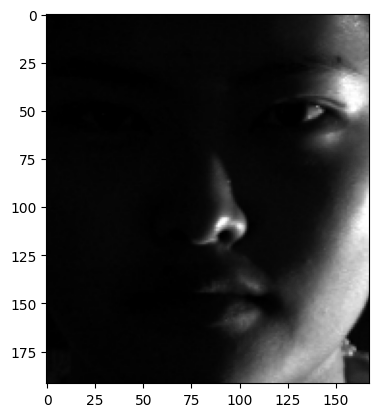

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


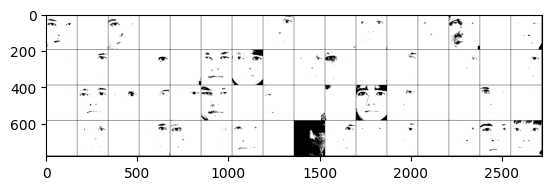

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
input = train_dataset[0][0].reshape(1, 1, 192, 168)
# 觀察 network 輸出結果
out = net(input.to(device))
print(out.to("cpu").detach().numpy().shape)
print(out.data)
print(out.data.max(1, keepdim=True)[1])
print(out.to("cpu").detach().numpy())
 
# get some random training images
dataiter = iter(train_loader) # an iterable object
images, labels = next(dataiter) # get the next batch
print(images.shape)
 
# show a single image
a_image = images[0]
a_image_ = np.transpose(a_image, (1, 2, 0))
plt.imshow(a_image_, cmap='gray')
plt.show()
 
# show a grid of images
montage = torchvision.utils.make_grid(images, nrow=16) # make a grid of images with 16 images per row
plt.imshow(np.transpose(montage, (1, 2, 0)), cmap='gray')
plt.show()

define loss function 

In [41]:
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9,weight_decay=1e-4)
optimizer = torch.optim.Adam(net.parameters(), lr = 0.001)

train the net work 

In [42]:
epochs = 50 ###
for epoch in range(epochs):  # loop over the dataset multiple times
 
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device) # move to GPU if available
     
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs) # forward pass
        loss = criterion(outputs, labels) # compute loss
        # writer.add_scalar("Loss/train", loss, epoch)
        loss.backward() # compute gradients
        optimizer.step() # update weights
 
        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print(f'[epoch : {epoch + 1}, batch: {i + 1:5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0
 
print('Finished Training')

Finished Training


save the trained model for later use

In [43]:
PATH = './digit10_net.pt' # .pth will collide with the PyTorch JIT
torch.save(net.state_dict(), PATH)

Test the network on the test data

In [52]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
 
print(f'Accuracy of the network on the  test images: {100 * correct // total} %')

Accuracy of the network on the  test images: 97 %


 <hr>

Predicted label: 33


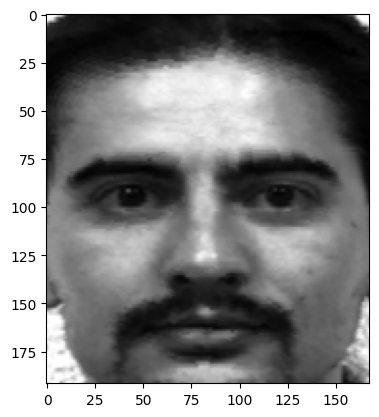

In [97]:
import torch
import torchvision.transforms as transforms
from PIL import Image

# 1. 載入模型
net.load_state_dict(torch.load(PATH))
net.eval()


# 2. 定義測試影像的預處理
transform = transforms.Compose([
    #transforms.Resize((224, 224)),  # 請確保你的模型接受的輸入大小是 (224, 224)，否則需要做相應調整
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # 根據你的訓練時的正規化參數調整
])


# 3. 載入測試影像並進行預處理
image = Image.open("D:/shallow_ml/pictures/man.jpg")  # 請替換成你的測試影像路徑
image = image.convert("L")
plt.imshow(image, cmap = 'gray') #將原圖列印出
image = transform(image)  # 將圖像轉換為tensor並進行正確的預處理
image = image.unsqueeze(0)  # 增加 batch 維度，因為模型預期的輸入是一批影像
image = image.to(device)  # 將圖像移動到設備上

# 4. 使用模型進行預測
with torch.no_grad():
    output = net(image)

# 取得預測結果
predicted_label = torch.argmax(output, dim=1).item()

# 列印預測結果
print("Predicted label:", predicted_label)




C:\Users\yangs\AppData\Local\Temp\ipykernel_11688\630197496.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  img_height = int(df['n'])
C:\Users\yangs\AppData\Local\Temp\ipykernel_11688\630197496.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  img_width = int(df['m'])


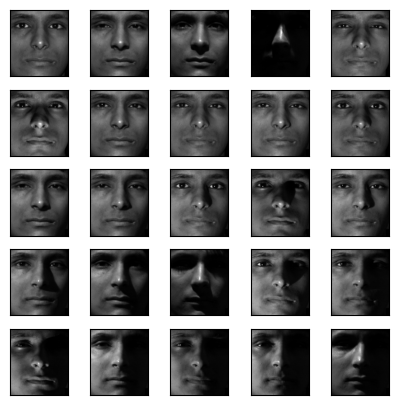

In [95]:
def show_montage(X, n, m, h, w):
    '''
    X: 影像資料矩陣，每行代表一張影像
    n,m: 每張影像的大小 nxm
    h,w: 建立一個蒙太奇圖陣，大小 figsize=(w,h)
    '''
    fig, axes = plt.subplots(h, w, figsize=(w, h))
    if X.shape[1] < w * h: 
        X = np.c_[X, np.zeros((X.shape[0], w*h - X.shape[1]))]
    for i, ax in enumerate(axes.flat):
        ax.imshow(X[:,i].reshape(m, n).T, cmap='gray') #.T
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

# 找到所有標籤為33的人臉
indices_label = np.where(y == 33)[0]

# 提取所有標籤為33的人臉影像
faces_label = X[indices_label]

# 設置每張人臉影像的大小
img_height = int(df['n'])
img_width = int(df['m'])

# 顯示蒙太奇圖
show_montage(faces_label.T, img_height, img_width, 5, 5)  # 將影像矩陣轉置以符合 show_montage 函式的要求


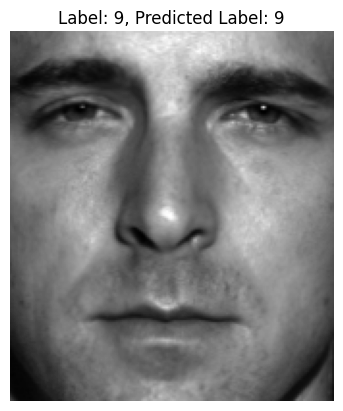

In [101]:
images, labels = next(iter(test_loader))
index = np.random.randint(len(images))
image = images[index]
label = labels[index]

with torch.no_grad():
    output = net(image.unsqueeze(0).to(device))
    _, predicted_label = torch.max(output, 1)

image_np = image.squeeze().numpy()
plt.imshow(image_np, cmap = 'gray')
plt.title(f"Label: {label.item()}, Predicted Label: {predicted_label.item()}")
plt.axis('off')
plt.show()